In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import sklearn
import os
import subprocess
import json
import sys
import csv
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from matplotlib.pyplot import subplots


In [94]:
#file names, should try to automate more
VCF_FILE_NAME = 'ERR6634978-ERR6635032-7030.vcf.gz' #this needs to be changed as well 
VCF_PATH='/mnt/storage7/lwang/trial_tb_philippines/data/processed/seqtk/freebayesVCF'
VCF_FILE_PATH = os.path.join(VCF_PATH, VCF_FILE_NAME)
JSON_FILE_PATH = os.path.join(VCF_PATH, 'results/ERR6634978-ERR6635032-8020.results.json') #for the time being, change the file names here

with open(JSON_FILE_PATH, 'r') as f:
    json_labelling = json.load(f)

with open('ROAO_proportion.csv', 'w') as f:
    subprocess.run(['bcftools', 'query', '-f', '[%POS,%RO,%AO,%DP\n]', VCF_FILE_PATH], shell=False, stdout=f, text=True)

#count how many column there is in the ROAO_proportion.csv file this is needed in order to read the csv in a a panda dataframe
import csv

f = open('ROAO_proportion.csv')

data = []
num_col=0
for line in f:
    data_line = line.rstrip().split('\n')
    data_line = data_line[0].split(',')
    data_line = [int(i) for i in data_line]
    if len(data_line) > num_col:
        num_col = len(data_line)
    data.append(data_line)

#print(num_col) #outputing the length of column in the dataframe
num_RO = num_col - 1
#print(num_RO)


In [95]:
df = pd.read_csv('ROAO_proportion.csv', names=range(num_col)) #doesn't include the 4th colum
df.fillna(value=0, inplace=True)

df[2] = df.iloc[:, 2:].sum(axis=1)
df = df.iloc[:,:3]
df[df.shape[1]] = None #create an additional column here as a empty column of zero, this column is for the drug resistance info
df_np = df.to_numpy()

In [96]:
def graph_ratio(name, prediction, df_np, output1=0, output2=1):

    df_np_temp = df_np[:,0:3]
    df_np_temp = np.insert(df_np_temp, 3, prediction, axis=1)

    number_of_labels0 = len(prediction[prediction==output1])
    number_of_labels1 = len(prediction[prediction==output2])
    labels = np.unique(prediction)
    print('Unique output values', labels)
    print('ref to alt ratio', number_of_labels0/(number_of_labels0+number_of_labels1),':',number_of_labels1/(number_of_labels1+number_of_labels0))


    fig, ax = subplots(nrows=1, ncols=3, figsize=(20, 7))

    ax[0].scatter(df_np_temp[:,1], df_np_temp[:,2], c=df_np_temp[:,3], s=15, cmap='bwr', alpha=0.2)
    ax[0].set_title(f"{name}_two strains")

    ax[1].scatter(df_np_temp[df_np_temp[:,3]==output1][:,1], df_np_temp[df_np_temp[:,3]==output1][:,2], c='b', s=15, cmap='bwr', alpha=0.2)
    ax[1].set_title(f"{name}_starin0")
    ax[1].set_xlim(0,800)
    ax[2].set_ylim(0,600)


    ax[2].scatter(df_np_temp[df_np_temp[:,3]==output2][:,1], df_np_temp[df_np_temp[:,3]==output2][:,2], c='r', s=15, cmap='bwr', alpha=0.2)
    ax[2].set_title(f"{name}_strain2")

<h1>One variable

In [97]:
df_np

array([[1302, 146, 234.0, None],
       [1977, 0, 390.0, None],
       [2532, 128, 266.0, None],
       ...,
       [4408920, 108, 168.0, None],
       [4410386, 163, 323.0, None],
       [4411016, 120, 243.0, None]], dtype=object)

Unique output values [0 1]
ref to alt ratio 0.2907898332877836 : 0.7092101667122165


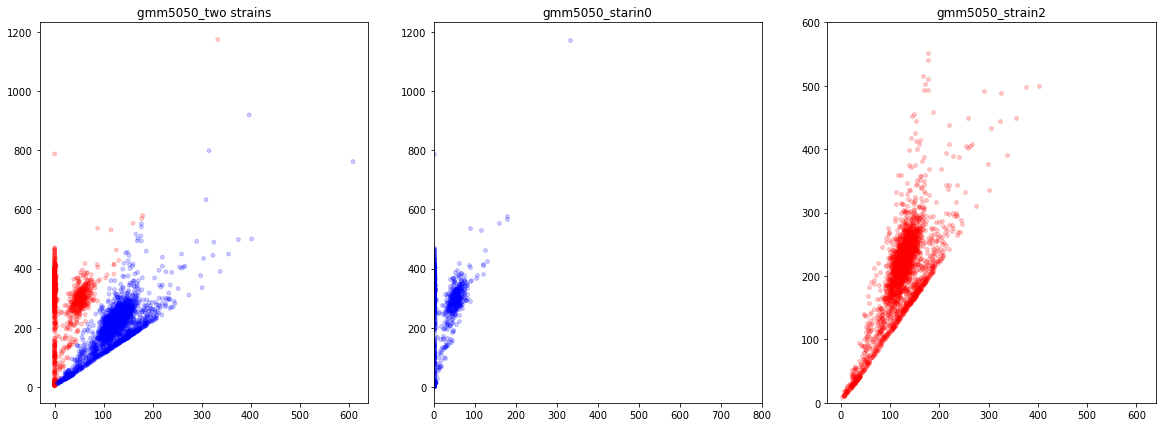

In [98]:
df_np_nz = []

for x in df_np:
    if x[1]==0 and x[2]==0:
        pass
    elif x[2]==0:
        pass
    else:
        df_np_nz.append(x)

df_np_nz = np.array(df_np_nz)

sum_ = df_np_nz[:,1] + df_np_nz[:,2]
freq = df_np_nz[:,2] / sum_
np.array(freq)

gm = GaussianMixture(n_components=2, random_state=0, covariance_type="full")
#gm.fit(df_np[:,freq])
gm.fit(freq.reshape(-1,1)) #one variable version


predictions = []

for x in freq:
    output = gm.predict(np.array(x).reshape(-1,1))
    predictions.append(output)

predictions_list = []
for x in predictions: #turn prediction which is a list of arrays of single values into a normal list
    predictions_list.append(x[0])

df_np_nz = np.insert(df_np_nz, 3, predictions_list, axis=1)

graph_ratio('gmm5050', df_np_nz[:,3],df_np_nz, output1=1, output2=0 )


In [65]:
df_np_nz[:,1]+df_np_nz[:,2]

array([188.0, 233.0, 193.0, ..., 136.0, 245.0, 182.0], dtype=object)

In [64]:
df_np_nz

array([[1302, 104, 84.0, None],
       [1977, 0, 233.0, None],
       [2532, 81, 112.0, None],
       ...,
       [4408920, 82, 54.0, None],
       [4410386, 125, 120.0, None],
       [4411016, 89, 93.0, None]], dtype=object)